In [17]:
import torch
import taxus as tx
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from plotnine import (
    ggplot, geom_point, geom_jitter, geom_line, geom_smooth, geom_ribbon, geom_rect, geom_boxplot,
    aes, facet_wrap, theme_bw, theme_void, theme_matplotlib, theme_linedraw, theme_minimal, theme_seaborn,
    theme, ylim, ggtitle
)
import patchworklib as pw

train_x_df = pd.DataFrame(
    dict(
        a=[1., 2., 2., 4.],
        b=[3., 4., 2., 5.],
        c=[5., 6., 6., 9.]
    )
)

train_y_df = pd.DataFrame(
    dict(
        d=[10., 15., 20., 21.],
        e=[30., 14., 21., 25.],
    )
).T
gp = tx.GP('~ a + b + c', train_x_df, pd.DataFrame(train_y_df.loc['e']), likelihood='poisson', kernel='rbf')
gp.fit(debug=True)

Fitting GP:  16%|███████████████████████▊                                                                                                                             | 96/600 [00:02<00:11, 42.59it/s, loss=3.92]


3.9166576862335205

<Figure size 72x72 with 0 Axes>

In [2]:
dict(gp.covar_module.named_parameters())

{'raw_outputscale': Parameter containing:
 tensor(-3.4250, requires_grad=True),
 'base_kernel.raw_lengthscale': Parameter containing:
 tensor([[-1.6107, -1.0448, -1.0373]], requires_grad=True)}

In [3]:
dict(gp.mean_module.named_parameters())

{'constant': Parameter containing:
 tensor([3.0770], requires_grad=True)}

In [4]:
torch.log(gp.train_y.mean())

tensor(3.1135)

In [5]:
import numpy as np

# x = np.arange(1, 13.1, .1)
x = np.array([*[2]*7, *[5]*5, *[7.2]*10, *[10]*2])
y = 30 * (np.exp(np.sin(x) * .3 * x) + (2 * np.random.rand(len(x))))

train_x_df = pd.DataFrame(dict(x=x))
train_y_df = pd.DataFrame(dict(y=y))

test_x_df = pd.DataFrame(dict(x=np.unique(x)))


gp1 = tx.GP('~ x', train_x_df, train_y_df, likelihood='poisson', kernel='rbf')
gp1.fit(n_steps=5000, tol=1e-6, lr=0.05, debug=True)
percentiles1 = gp1.predict(test_x_df, percentiles=[1, 25, 50, 75, 99])

gp2 = tx.GP('~ C(x)', train_x_df, train_y_df, likelihood='nb', kernel='linear')
gp2.fit(n_steps=5000, tol=1e-6, lr=0.01, debug=True)
percentiles2 = gp2.predict(test_x_df, percentiles=[1, 25, 50, 75, 99])

train_df = pd.concat([train_x_df, train_y_df], axis=1)
test_df1 = pd.concat([test_x_df, percentiles1], axis=1)
test_df2 = pd.concat([test_x_df, percentiles2], axis=1)

Fitting GP:  33%|████████████████████████████████████████████████▋                                                                                                 | 1667/5000 [00:04<00:08, 402.32it/s, loss=4.8]


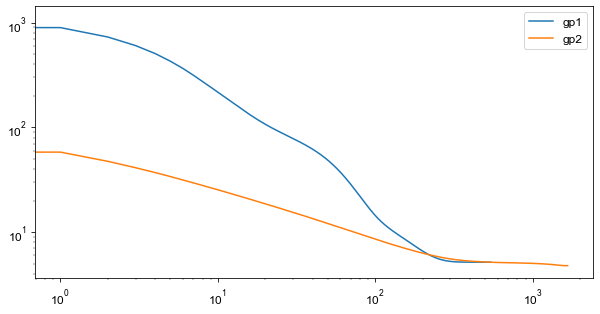

In [6]:
fig,ax = plt.subplots(1, figsize=(10,5))
ax.plot(gp1.losses_, label='gp1')
ax.plot(gp2.losses_, label='gp2')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

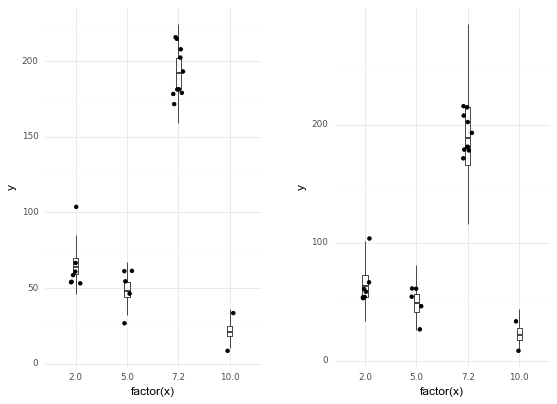

In [7]:
p1 = (
    ggplot(train_df, aes(x='factor(x)', y='y'))
    + geom_boxplot(aes(x='factor(x)', ymin='p1', lower='p25', middle='p50', upper='p75',
                       ymax='p99', group='x'),
                   data=test_df1, inherit_aes=False, alpha=0.5, stat='stat_identity', width=.1)
    + geom_jitter(width=.1)
    + theme_minimal()
)

p2 = (
    ggplot(train_df, aes(x='factor(x)', y='y'))
    + geom_boxplot(aes(x='factor(x)', ymin='p1', lower='p25', middle='p50', upper='p75',
                       ymax='p99', y='mean', group='x'),
                   data=test_df2, inherit_aes=False, alpha=0.5, stat='stat_identity', width=.1)
    + geom_jitter(width=.1)
    + theme_minimal()
)

p1 = pw.load_ggplot(p1, figsize=(3,5))
p2 = pw.load_ggplot(p2, figsize=(3,5))
p12 = (p1|p2)
p12.savefig()


In [15]:

gp = tx.GP('~ x', train_x_df, train_y_df, likelihood='poisson', kernel='rbf')
gp.fit(n_steps=10000, tol=1e-6, lr=0.1, debug=True)
optimized_lengthscale = gp.covar_module.base_kernel.lengthscale
optimized_lengthscale

Fitting GP:   3%|███▊                                                                                                                                             | 259/10000 [00:00<00:19, 493.90it/s, loss=5.18]


tensor([[0.1187]], grad_fn=<SoftplusBackward0>)

In [16]:
# gp.covar_module.base_kernel.lengthscale = torch.tensor([.1])
test_x_df = pd.DataFrame(dict(x=np.arange(2,12,.1)))
percentiles = gp.predict(test_x_df)
train_df = pd.concat([train_x_df, train_y_df], axis=1)
test_df = pd.concat([test_x_df, percentiles], axis=1)

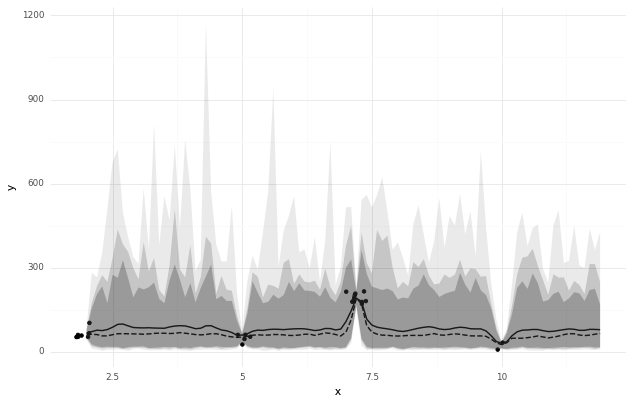

In [17]:
p = (
    ggplot(train_df, aes(x='x', y='y'))
    + geom_jitter(width=.2)
    + geom_smooth(aes(x='x', y='p50'), method='lowess', span=.05, linetype='dashed', alpha=.7, size=.8,
                 data=test_df, inherit_aes=False)
    + geom_smooth(aes(x='x', y='mean'), method='lowess', span=.05, alpha=.7, size=.8,
                 data=test_df, inherit_aes=False)
    + geom_ribbon(mapping=aes(x='x', ymin='p0.5', ymax='p99.5'), alpha=.1,
                 data=test_df, inherit_aes=False)
    + geom_ribbon(mapping=aes(x='x', ymin='p2.5', ymax='p97.5'), alpha=.2,
                 data=test_df, inherit_aes=False)
    + geom_ribbon(mapping=aes(x='x', ymin='p5', ymax='p95'), alpha=.3,
                 data=test_df, inherit_aes=False)
    + theme_minimal()
)

pw.load_ggplot(p, figsize=(8,5)).savefig()

In [11]:
from statsmodels.nonparametric.smoothers_lowess import lowess

{'raw_outputscale': Parameter containing:
 tensor(-0.1559, requires_grad=True),
 'base_kernel.raw_lengthscale': Parameter containing:
 tensor([[-5.6992]], requires_grad=True)}

In [19]:
percentiles['p0.5']

0     44.0
1     12.0
2      9.0
3      4.0
4      8.0
      ... 
95     8.0
96    10.0
97     8.0
98     7.0
99    10.0
Name: p0.5, Length: 100, dtype: float64

In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv('./docs/examples/salmon.merged.gene_counts.tsv', sep='\t', index_col=[0,1])
norm_df = tx.deseq_normalization(df)
norm_df

FileNotFoundError: [Errno 2] No such file or directory: './docs/examples/salmon.merged.gene_counts.tsv'

In [ ]:
from plotnine import (
    ggplot, geom_point, geom_jitter, geom_line, geom_smooth, geom_ribbon, geom_rect, geom_boxplot,
    aes, facet_wrap, theme_bw, theme_void, theme_matplotlib, theme_linedraw, theme_minimal, theme_seaborn,
    theme, ylim, ggtitle, scale_y_continuous
)

covariates = pd.DataFrame(
    [[float(c[0]), 0.0 if c[1] == 'CL' else 1.0] for c in (c[1:].split('_') for c in df.columns)],
    columns=['time','treatment'],
    index=df.columns
)

expression = norm_df.loc['AT1G01010'].T
expression.columns = ['expression']
gp = tx.GP('~ time + treatment', covariates, expression, likelihood='gaussian', kernel='rbf')
gp.fit(n_steps=20000, lr=0.1, tol=1e-6)
fig,ax = plt.subplots(1, figsize=(8,4))
ax.plot(gp.losses_)
#ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
x_range = range(-50,100)

test_x = pd.DataFrame(dict(
    time=list(x_range) * 2,
    treatment=[*[0]*len(x_range), *[1]*len(x_range)]
),dtype=np.float32)
percentiles = gp.predict(test_x)


train_df = pd.concat([covariates, expression], axis=1)
test_df = pd.concat([test_x, percentiles], axis=1)
(
    ggplot(train_df, aes(x='time', y='expression', group='treatment'))
    + geom_point(aes(color='factor(treatment)'))
    + geom_line(aes(x='time',y='p50', color='factor(treatment)'), data=test_df, inherit_aes=False, )
    + geom_ribbon(aes(x='time', ymin='p5', ymax='p95', fill='factor(treatment)'), alpha=.3, data=test_df, inherit_aes=False,)
    + geom_ribbon(aes(x='time', ymin='p2.5', ymax='p97.5', fill='factor(treatment)'), alpha=.2, data=test_df, inherit_aes=False,)
    + geom_ribbon(aes(x='time', ymin='p0.5', ymax='p99.5', fill='factor(treatment)'), alpha=.1, data=test_df, inherit_aes=False,)
    + scale_y_continuous(limits=(0, test_df.max().max()))
    + theme_minimal()
)

In [ ]:
len(range(-25,75))

In [ ]:
dict(gp.mean_module.named_parameters()),torch.log(torch.tensor(expression.mean()))

In [ ]:
dict(gp.covar_module.named_parameters())

In [ ]:
torch.max(torch.diff(gp.train_x, axis=0), axis=0).values

In [ ]:
fig,ax = plt.subplots(1, figsize=(10,5))
ax.plot(gp.losses_)
ax.set_yscale('log')
ax.set_xscale('log')

In [15]:
from taxus.likelihoods import NegativeBinomial

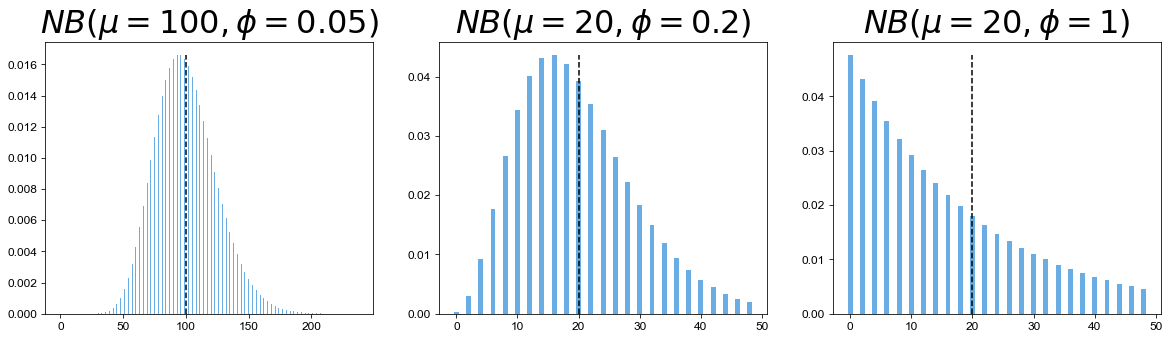

In [19]:
nb1 = NegativeBinomial(mu=100, phi=20.)
x1 = torch.arange(0, 240, 3)
prob1 = np.exp(nb1.log_prob(x1))

nb2 = NegativeBinomial(mu=20, phi=5.)
x2 = torch.arange(0, 50, 2)
prob2 = np.exp(nb2.log_prob(x2))

nb3 = NegativeBinomial(mu=20, phi=1.)
x3 = torch.arange(0, 50, 2)
prob3 = np.exp(nb3.log_prob(x3))

fig, [ax1,ax2,ax3] = plt.subplots(ncols=3, figsize=(20,5))

ax1.bar(x1, prob1, color='#6aade4')
ax1.plot([100, 100],[0, max(prob1)], c='k', linestyle='--')
ax1.set_title('$NB(\mu=100, \phi=0.05)$', size=32, font='helvetica')

ax2.bar(x2, prob2, color='#6aade4')
ax2.plot([20, 20],[0, max(prob2)], c='k', linestyle='--')
ax2.set_title('$NB(\mu=20, \phi=0.2)$', size=32, font='helvetica')

ax3.bar(x3, prob3, color='#6aade4')
ax3.plot([20, 20],[0, max(prob3)], c='k', linestyle='--')
ax3.set_title('$NB(\mu=20, \phi=1)$', size=32, font='helvetica')
fig.savefig('negative_binomial_examples.png')

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
df = pd.read_csv("http://bowtie-bio.sourceforge.net/recount/countTables/bottomly_count_table.txt", sep='\t', index_col=0)
df

expr_df = df.loc[(df > 0).sum(axis=1) > 0]
mean = expr_df.mean(axis=1)
var = expr_df.var(axis=1)

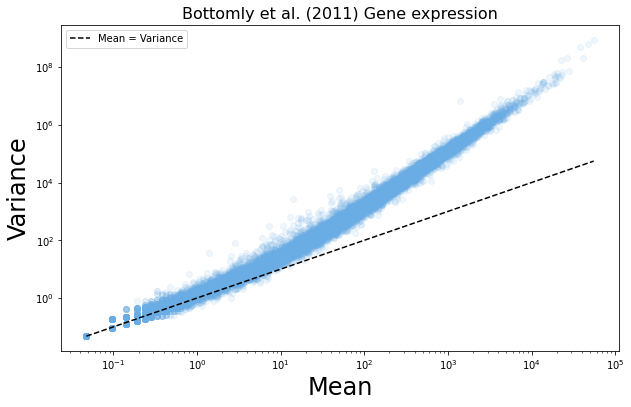

In [13]:
fig,ax = plt.subplots(1, figsize=(10,6))
ax.scatter(mean, var, alpha=.1, c='#6aade4')
ax.plot([mean.min(),mean.max()],[mean.min(),mean.max()], c='k', linestyle='--', label='Mean = Variance')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Mean', fontsize=24)
ax.set_yscale('log')
ax.set_ylabel('Variance', fontsize=24)
ax.set_title('Bottomly et al. (2011) Gene expression', fontsize=16)
fig.savefig('bottomly_overdispersion.png')